In [1]:
pip install pandas numpy matplotlib scikit-learn

In [5]:
import pandas as pd
df=pd.read_csv('Binance_BTCUSDT_4h_from_1h.csv')
df.head()

,date,open,high,low,close,volume_btc,tradecount
0,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,171
1,2017-08-17 08:00:00,4308.83,4377.85,4287.41,4360.69,35.880663,191
2,2017-08-17 12:00:00,4360.00,4485.39,4360.00,4411.00,85.679473,328
3,2017-08-17 16:00:00,4411.00,4485.39,4255.30,4354.18,218.988394,1148
4,2017-08-17 20:00:00,4354.18,4354.84,4200.74,4346.74,206.626397,835


Loading CSV...
Adding daily trend & indicators...
Detecting patterns (double & triple + sweep)...
Detected patterns: 46750
Performing strict walk-forward + holdout prediction...
Predictions: 36118
Running backtest with exposure caps and single-active-trade rule...
Performance: {'total_return': np.float64(1.1349442997304608), 'cagr': np.float64(0.13710792650633907), 'trades': 919, 'win_rate': 0.6017410228509249, 'sharpe': np.float64(3.803962910237817), 'max_dd': np.float64(-0.03802180408485915)}


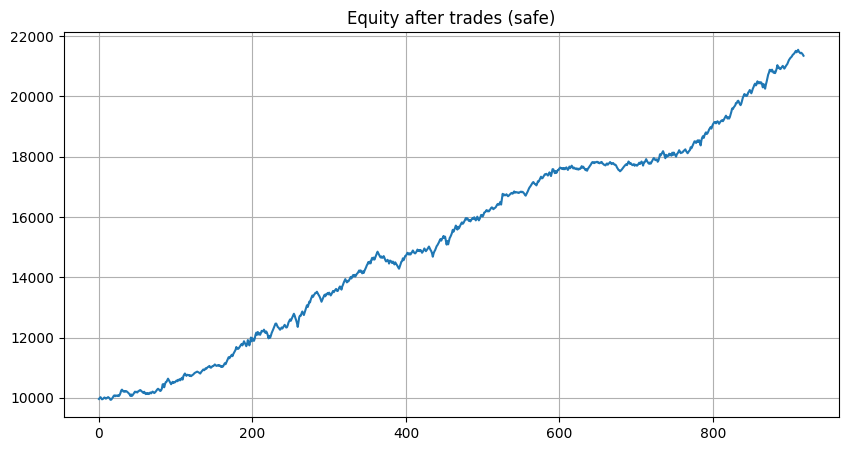

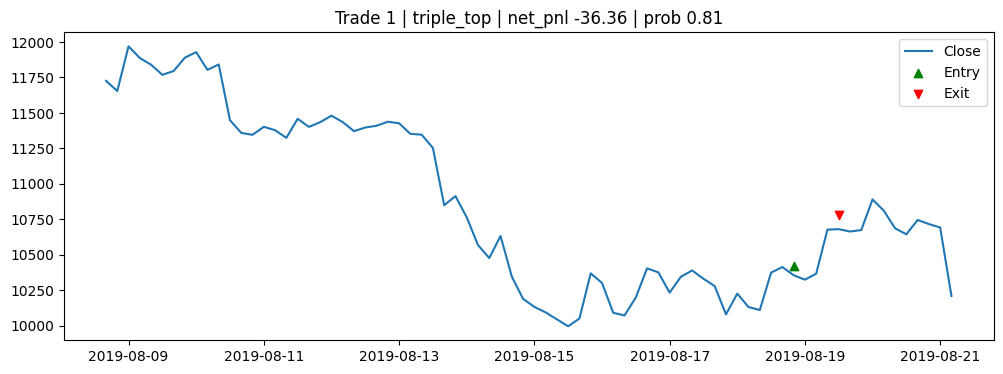

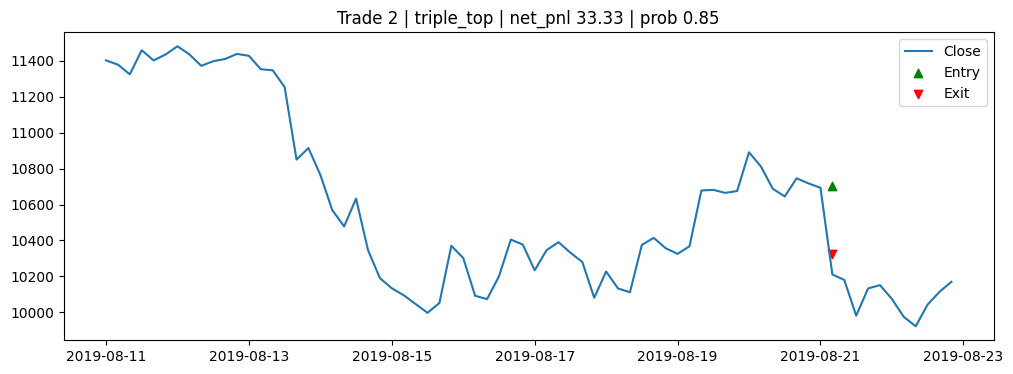

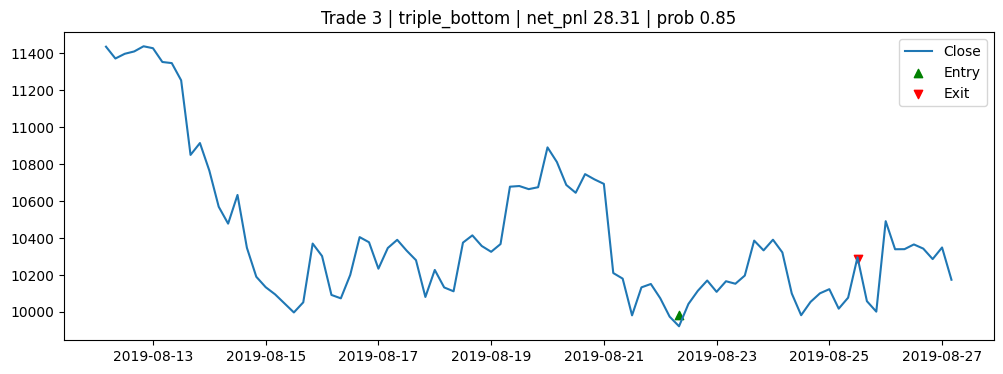

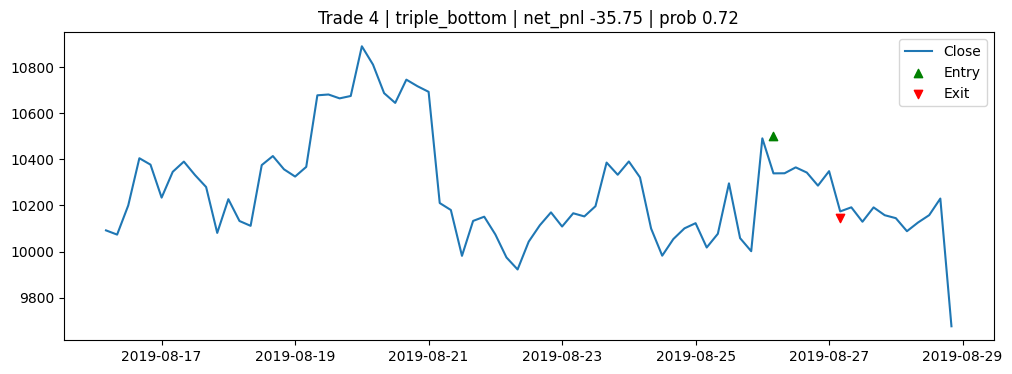

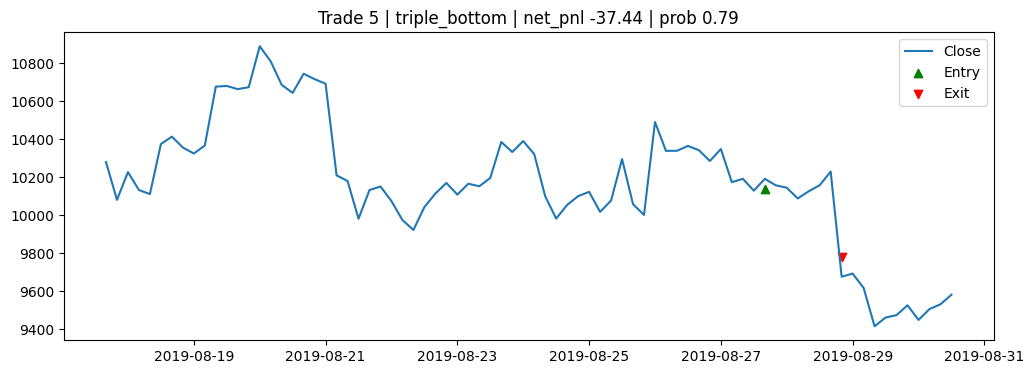

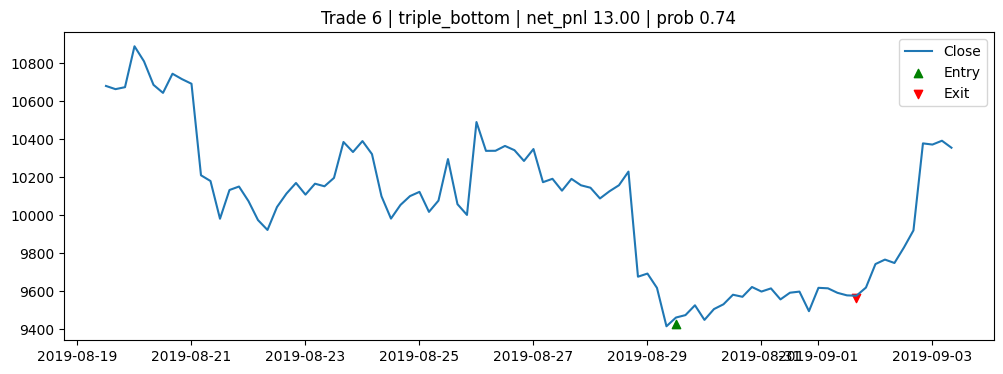

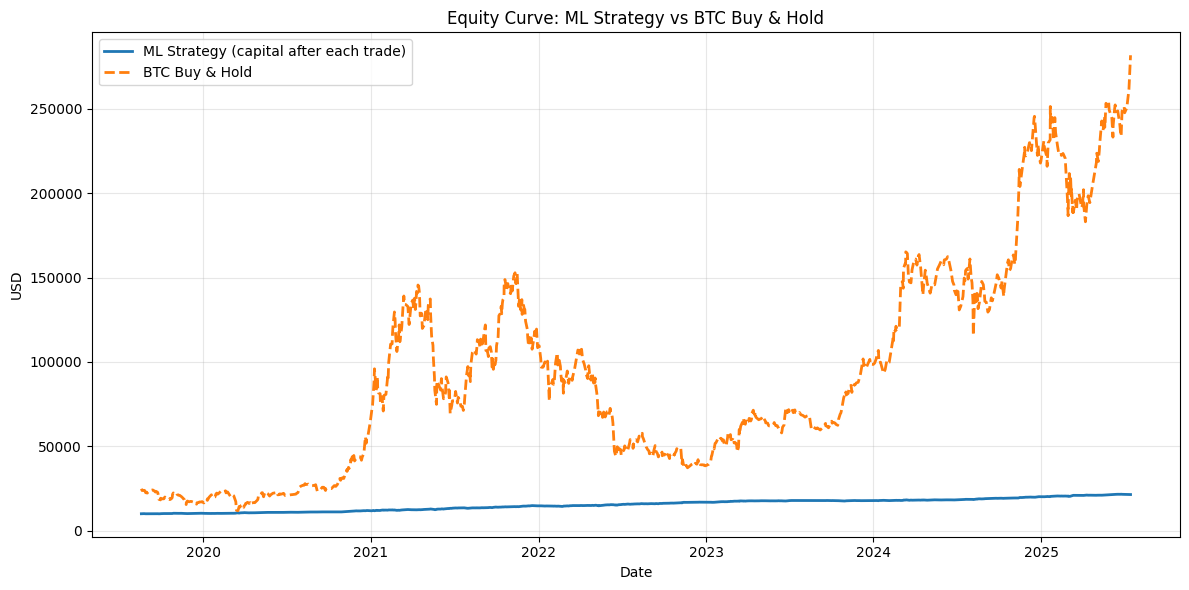

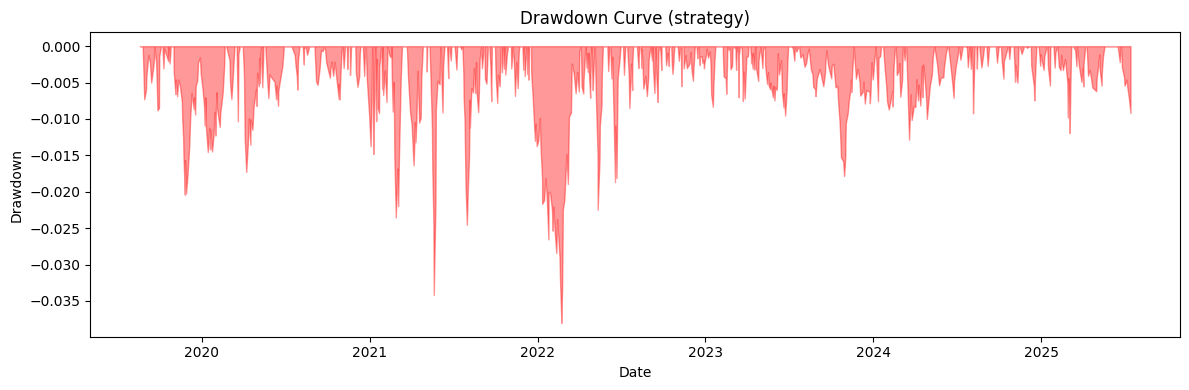

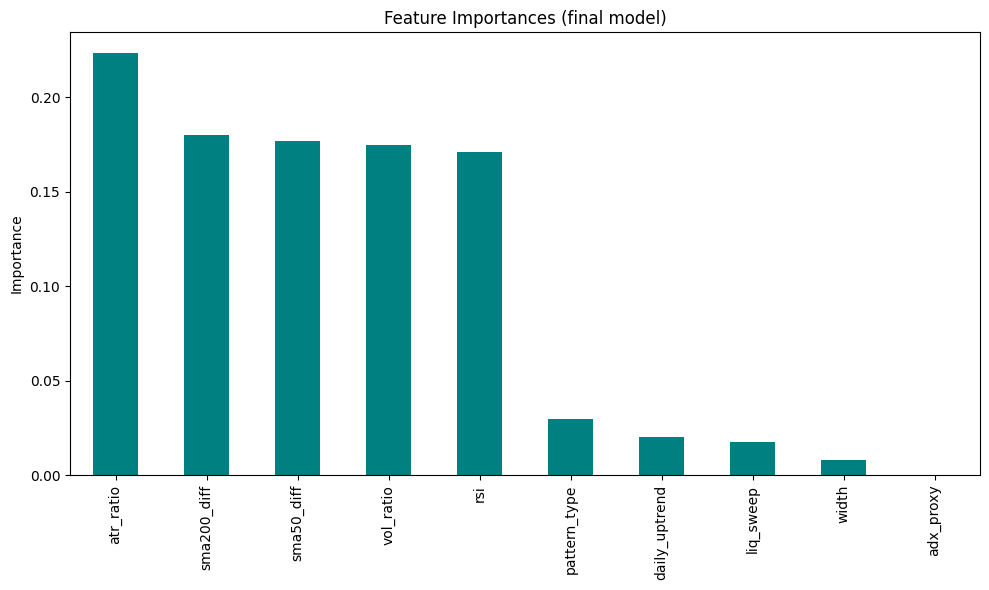

In [29]:
# pattern_ml_walkforward_safe_fixed.py
# Fixed final block + plotting for equity, drawdown, and feature importances.
# (Rest of pipeline same as your previous code.)

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import warnings
from math import sqrt
warnings.filterwarnings("ignore")

# ----------------------------
# CONFIG (tweak these safely)
# ----------------------------
CSV_FILE = "Binance_BTCUSDT_4h_from_1h.csv"
DATE_COL = "date"

LOOKAHEAD_LABEL = 20           # candles used to label pattern success
SUCCESS_THRESHOLD = 0.02       # 2% move
WF_TRAIN_DAYS = 365 * 2
WF_TEST_DAYS = 90
FINAL_HOLDOUT_DAYS = 180      # keep final N days fully out-of-sample
PROB_THRESHOLD = 0.6
INITIAL_CAPITAL = 10000.0
POSITION_RISK = 0.01           # fraction of capital risked per trade
MAX_NOTIONAL_EXPOSURE = 0.10   # max notional exposure as fraction of capital (10%)
MIN_STOP_PCT = 0.001           # min stop distance as fraction of entry price (0.1%)
COMMISSION = 0.001             # 0.1% per side
SLIPPAGE = 0.001               # 0.1% slippage
RANDOM_STATE = 42

# ----------------------------
# Indicators (past-only rolling)
# ----------------------------
def sma(series, window):
    return series.rolling(window=window, min_periods=1).mean()

def rsi(series, window=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.ewm(alpha=1/window, adjust=False).mean()
    ma_down = down.ewm(alpha=1/window, adjust=False).mean()
    rs = ma_up / (ma_down + 1e-9)
    return 100 - (100 / (1 + rs))

def atr(df, window=14):
    high_low = df['High'] - df['Low']
    high_close = (df['High'] - df['Close'].shift()).abs()
    low_close = (df['Low'] - df['Close'].shift()).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return tr.rolling(window=window, min_periods=1).mean()

def adx_proxy(df, window=14):
    up_move = df['High'].diff()
    down_move = -df['Low'].diff()
    plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0.0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)
    tr = pd.concat([(df['High'] - df['Low']).abs(),
                    (df['High'] - df['Close'].shift()).abs(),
                    (df['Low'] - df['Close'].shift()).abs()], axis=1).max(axis=1)
    plus_di = 100 * pd.Series(plus_dm).rolling(window).sum() / (tr.rolling(window).sum() + 1e-9)
    minus_di = 100 * pd.Series(minus_dm).rolling(window).sum() / (tr.rolling(window).sum() + 1e-9)
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di + 1e-9)) * 100
    return dx.rolling(window).mean()

# ----------------------------
# Load + standardize CSV
# ----------------------------
def load_csv(fn):
    df = pd.read_csv(fn, parse_dates=[DATE_COL])
    df.columns = [c.strip() for c in df.columns]
    lower = {c.lower(): c for c in df.columns}
    mapping = {}
    for key in ['date','open','high','low','close','volume','volume_btc','tradecount']:
        if key in lower:
            mapped = lower[key]
            if key == 'date':
                mapping[mapped] = 'Date'
            elif key in ['volume','volume_btc']:
                mapping[mapped] = 'Volume'
            else:
                mapping[mapped] = key.capitalize()
    df = df.rename(columns=mapping)
    for c in ['Date','Open','High','Low','Close']:
        if c not in df.columns:
            raise ValueError(f"Missing column after mapping: {c}")
    if 'Volume' not in df.columns:
        df['Volume'] = 0
    df = df.sort_values('Date').reset_index(drop=True)
    return df

# ----------------------------
# Daily trend mapping
# ----------------------------
def add_daily_trend(df):
    df_daily = df.set_index('Date').resample('1D').agg({'Open':'first','High':'max','Low':'min','Close':'last','Volume':'sum'}).dropna().reset_index()
    df_daily['SMA50'] = sma(df_daily['Close'], 50)
    df_daily['SMA200'] = sma(df_daily['Close'], 200)
    df_daily['uptrend'] = df_daily['SMA50'] > df_daily['SMA200']
    df['day'] = df['Date'].dt.floor('D')
    map_df = df_daily[['Date','uptrend']].rename(columns={'Date':'day'})
    df = df.merge(map_df, on='day', how='left')
    df['uptrend'] = df['uptrend'].fillna(method='ffill').fillna(False)
    return df

# ----------------------------
# Local extrema (used for pattern detection)
# ----------------------------
def local_extrema(df, lookback=3):
    low = df['Low']
    high = df['High']
    is_min = (low == low.rolling(window=2*lookback+1, center=True).min()).fillna(False)
    is_max = (high == high.rolling(window=2*lookback+1, center=True).max()).fillna(False)
    return is_min.astype(bool), is_max.astype(bool)

# ----------------------------
# Detect double & triple tops/bottoms + liquidity sweep
# ----------------------------
def detect_double_triple_patterns(df, min_sep=4, max_sep=120, lookback_sweep=24):
    patterns = []
    is_min, is_max = local_extrema(df, lookback=3)
    mins = df.index[is_min].tolist()
    maxs = df.index[is_max].tolist()
    N = len(df)

    def liquidity_sweep_at(i):
        start = max(0, i - lookback_sweep)
        prev_min = df['Low'].iloc[start:i].min() if i - start > 0 else df['Low'].iloc[i]
        prev_max = df['High'].iloc[start:i].max() if i - start > 0 else df['High'].iloc[i]
        sweep_low = df['Low'].iloc[i] < prev_min
        sweep_high = df['High'].iloc[i] > prev_max
        return bool(sweep_low), bool(sweep_high)

    # Double bottoms
    for a_idx in range(len(mins)):
        for b_idx in range(a_idx+1, len(mins)):
            a = mins[a_idx]; b = mins[b_idx]
            sep = b - a
            if sep < min_sep: continue
            if sep > max_sep: break
            mid_peak = df['High'].iloc[a:b+1].max()
            if mid_peak > max(df['Low'].iloc[[a,b]]) * 1.01:
                sweep_low, _ = liquidity_sweep_at(b)
                patterns.append({'index': int(b), 'type':'double_bottom', 'width': sep, 'liq_sweep': sweep_low})
                break

    # Triple bottoms
    for i in range(len(mins)):
        for j in range(i+1, len(mins)):
            for k in range(j+1, len(mins)):
                a = mins[i]; b = mins[j]; c = mins[k]
                sep1 = b - a; sep2 = c - b
                if sep1 < min_sep or sep2 < min_sep: continue
                if sep1 > max_sep or sep2 > max_sep: break
                mid_peak = df['High'].iloc[a:c+1].max()
                if mid_peak > max(df['Low'].iloc[[a,b,c]]) * 1.01:
                    sweep_low, _ = liquidity_sweep_at(c)
                    patterns.append({'index': int(c), 'type':'triple_bottom', 'width': c-a, 'liq_sweep': sweep_low})
                    break

    # Double tops
    for a_idx in range(len(maxs)):
        for b_idx in range(a_idx+1, len(maxs)):
            a = maxs[a_idx]; b = maxs[b_idx]
            sep = b - a
            if sep < min_sep: continue
            if sep > max_sep: break
            mid_trough = df['Low'].iloc[a:b+1].min()
            if mid_trough < min(df['High'].iloc[[a,b]]) * 0.99:
                _, sweep_high = liquidity_sweep_at(b)
                patterns.append({'index': int(b), 'type':'double_top', 'width': sep, 'liq_sweep': sweep_high})
                break

    # Triple tops
    for i in range(len(maxs)):
        for j in range(i+1, len(maxs)):
            for k in range(j+1, len(maxs)):
                a = maxs[i]; b = maxs[j]; c = maxs[k]
                sep1 = b-a; sep2 = c-b
                if sep1 < min_sep or sep2 < min_sep: continue
                if sep1 > max_sep or sep2 > max_sep: break
                mid_trough = df['Low'].iloc[a:c+1].min()
                if mid_trough < min(df['High'].iloc[[a,b,c]]) * 0.99:
                    _, sweep_high = liquidity_sweep_at(c)
                    patterns.append({'index': int(c), 'type':'triple_top', 'width': c-a, 'liq_sweep': sweep_high})
                    break

    return patterns

# ----------------------------
# Extract past-only features + label
# ----------------------------
def extract_features(df, patterns, lookback=60):
    rows = []
    N = len(df)
    for p in patterns:
        i = int(p['index'])
        # require forward data for labeling
        if i + LOOKAHEAD_LABEL >= N:
            continue
        start = max(0, i - lookback + 1)
        past = df.iloc[start:i+1]
        row = {}
        row['index'] = i
        row['datetime'] = df['Date'].iloc[i]
        row['pattern_type'] = 1 if 'bottom' in p['type'] else 0
        row['original_pattern_type'] = p['type'] # Add original pattern type
        row['width'] = p.get('width', 0)
        row['liq_sweep'] = int(p.get('liq_sweep', False))
        # safe features computed only from 'past'
        row['sma50_diff'] = (past['Close'].iloc[-1] - sma(past['Close'],50).iloc[-1]) / (sma(past['Close'],50).iloc[-1] + 1e-9)
        row['sma200_diff'] = (past['Close'].iloc[-1] - sma(past['Close'],200).iloc[-1]) / (sma(past['Close'],200).iloc[-1] + 1e-9)
        row['rsi'] = rsi(past['Close'],14).iloc[-1] if len(past) >= 14 else 50.0
        row['atr_ratio'] = atr(past,14).iloc[-1] / (past['Close'].iloc[-1] + 1e-9)
        vol_sma20 = past['Volume'].rolling(20).mean().iloc[-1] if len(past) >= 20 else past['Volume'].mean()
        row['vol_ratio'] = past['Volume'].iloc[-1] / (vol_sma20 + 1e-9)
        row['adx_proxy'] = adx_proxy(past,14).iloc[-1] if len(past) >= 14 else 0.0
        row['daily_uptrend'] = int(df['uptrend'].iloc[i]) if 'uptrend' in df.columns else 0
        # label (uses future only for dataset creation)
        if row['pattern_type'] == 1:  # bottom
            future_max = df['Close'].iloc[i+1:i+1+LOOKAHEAD_LABEL].max()
            row['future_return_max'] = (future_max - past['Close'].iloc[-1]) / (past['Close'].iloc[-1] + 1e-9)
            row['success'] = int(row['future_return_max'] >= SUCCESS_THRESHOLD)
        else:  # top
            future_min = df['Close'].iloc[i+1:i+1+LOOKAHEAD_LABEL].min()
            row['future_return_min'] = (past['Close'].iloc[-1] - future_min) / (past['Close'].iloc[-1] + 1e-9)
            row['success'] = int(row['future_return_min'] >= SUCCESS_THRESHOLD)
        rows.append(row)
    return pd.DataFrame(rows)

# ----------------------------
# Strict walk-forward (non-overlapping test folds)
# ----------------------------
def walk_forward(feature_df, feature_cols, final_holdout_days=FINAL_HOLDOUT_DAYS):
    feature_df = feature_df.sort_values('datetime').reset_index(drop=True)
    # holdout cut
    cutoff = feature_df['datetime'].max() - pd.Timedelta(days=final_holdout_days)
    pool = feature_df[feature_df['datetime'] < cutoff].copy()
    holdout = feature_df[feature_df['datetime'] >= cutoff].copy()
    preds = []
    start = pool['datetime'].min()
    end = pool['datetime'].max()
    train_window = pd.Timedelta(days=WF_TRAIN_DAYS)
    test_window = pd.Timedelta(days=WF_TEST_DAYS)
    fold_start = start
    while True:
        train_start = fold_start
        train_end = train_start + train_window
        test_start = train_end
        test_end = test_start + test_window
        if test_start >= end:
            break
        train_rows = pool[(pool['datetime'] >= train_start) & (pool['datetime'] < train_end)]
        test_rows = pool[(pool['datetime'] >= test_start) & (pool['datetime'] < test_end)]
        if len(train_rows) < 50 or len(test_rows) < 5:
            fold_start = fold_start + test_window // 2
            if fold_start >= end:
                break
            continue
        # Select only numerical feature columns for training
        X_train = train_rows[feature_cols].select_dtypes(include=np.number).fillna(0)
        y_train = train_rows['success']
        X_test = test_rows[feature_cols].select_dtypes(include=np.number).fillna(0)
        clf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, class_weight='balanced')
        clf.fit(X_train, y_train)
        probs = clf.predict_proba(X_test)[:,1]
        test_rows = test_rows.copy()
        test_rows['pred_prob'] = probs
        preds.append(test_rows)
        fold_start = fold_start + test_window
    if len(preds) == 0:
        preds_df = pd.DataFrame()
    else:
        preds_df = pd.concat(preds).sort_values('datetime').reset_index(drop=True)
    # Optionally, predict on holdout using the last trained model
    if not pool.empty and not holdout.empty:
        final_clf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, class_weight='balanced')
        final_clf.fit(pool[feature_cols].select_dtypes(include=np.number).fillna(0), pool['success'])
        holdout = holdout.copy()
        holdout['pred_prob'] = final_clf.predict_proba(holdout[feature_cols].select_dtypes(include=np.number).fillna(0))[:,1]
        holdout['fold_train_start'] = pool['datetime'].min()
        holdout['fold_train_end'] = pool['datetime'].max()
        preds_df = pd.concat([preds_df, holdout]).sort_values('datetime').reset_index(drop=True)
    return preds_df

# ----------------------------
# Backtest engine (single active trade, exposure caps)
# ----------------------------
def backtest_with_preds(df, preds):
    trades = []
    capital = INITIAL_CAPITAL
    last_exit_idx = -1  # prevent overlapping trades
    for _, r in preds.sort_values('datetime').iterrows():
        if r['pred_prob'] < PROB_THRESHOLD:
            continue
        idx = int(r['index'])
        entry_idx = idx + 1
        if entry_idx >= len(df):
            continue
        # skip if we already have an active trade that ends after entry_idx
        if entry_idx <= last_exit_idx:
            continue
        entry_price = df['Open'].iloc[entry_idx] * (1 + SLIPPAGE)
        atr_at_idx = df['ATR'].iloc[idx] if not np.isnan(df['ATR'].iloc[idx]) else np.nan
        if np.isnan(atr_at_idx) or atr_at_idx <= 0:
            continue
        # enforce minimum stop distance (pct of price) to avoid tiny ATR issues
        min_stop = entry_price * MIN_STOP_PCT
        stop_dist = max(1.5 * atr_at_idx, min_stop)
        # risk amount + qty
        risk_amount = capital * POSITION_RISK
        qty = risk_amount / stop_dist
        # cap notional exposure
        notional = qty * entry_price
        max_notional = capital * MAX_NOTIONAL_EXPOSURE
        if notional > max_notional and notional > 0:
            qty = max_notional / entry_price
            # recalc risk_amount prox (approx)
            risk_amount = qty * stop_dist
        if qty <= 0:
            continue
        # simulate trade
        if r['pattern_type'] == 1:  # bottom -> long
            sl = entry_price - stop_dist
            tp = entry_price + 2.0 * atr_at_idx
            window = df.iloc[entry_idx: min(entry_idx+LOOKAHEAD_LABEL, len(df)-1)]
            hit_tp = window[window['High'] >= tp]
            hit_sl = window[window['Low'] <= sl]
            if not hit_tp.empty and (hit_sl.empty or hit_tp.index[0] <= hit_sl.index[0]):
                exit_price = tp * (1 - SLIPPAGE); exit_idx = hit_tp.index[0]; reason='tp'
            elif not hit_sl.empty:
                exit_price = sl * (1 - SLIPPAGE); exit_idx = hit_sl.index[0]; reason='sl'
            else:
                exit_price = window['Close'].iloc[-1] * (1 - SLIPPAGE); exit_idx = window.index[-1]; reason='timeout'
            gross = qty * (exit_price - entry_price)
            comm = (entry_price + exit_price) * qty * COMMISSION
            net = gross - comm
        else:  # top -> short
            sl = entry_price + stop_dist
            tp = entry_price - 2.0 * atr_at_idx
            window = df.iloc[entry_idx: min(entry_idx+LOOKAHEAD_LABEL, len(df)-1)]
            hit_tp = window[window['Low'] <= tp]
            hit_sl = window[window['High'] >= sl]
            if not hit_tp.empty and (hit_sl.empty or hit_tp.index[0] <= hit_sl.index[0]):
                exit_price = tp * (1 + SLIPPAGE); exit_idx = hit_tp.index[0]; reason='tp'
            elif not hit_sl.empty:
                exit_price = sl * (1 + SLIPPAGE); exit_idx = hit_sl.index[0]; reason='sl'
            else:
                exit_price = window['Close'].iloc[-1] * (1 + SLIPPAGE); exit_idx = window.index[-1]; reason='timeout'
            gross = qty * (entry_price - exit_price)
            comm = (entry_price + exit_price) * qty * COMMISSION
            net = gross - comm
        capital = capital + net
        trades.append({
            'pattern_idx': idx, 'entry_idx': entry_idx, 'exit_idx': int(exit_idx),
            'entry_price': entry_price, 'exit_price': exit_price, 'qty': qty,
            'net_pnl': net, 'capital_after': capital, 'type': r['original_pattern_type'], # Use the original_pattern_type
            'pred_prob': r['pred_prob'], 'exit_reason': reason,
            'datetime_entry': df['Date'].iloc[entry_idx], 'datetime_exit': df['Date'].iloc[exit_idx]
        })
        last_exit_idx = int(exit_idx)
    trades_df = pd.DataFrame(trades)
    if trades_df.empty:
        return trades_df, pd.Series(dtype=float)
    trades_df['ret'] = trades_df['net_pnl'] / INITIAL_CAPITAL
    equity = trades_df['capital_after'].reset_index(drop=True)
    return trades_df, equity

# ----------------------------
# Performance metrics
# ----------------------------
def compute_perf(trades_df, equity):
    if trades_df.empty:
        return {}
    total_return = equity.iloc[-1] / INITIAL_CAPITAL - 1.0
    days = (trades_df['datetime_exit'].max() - trades_df['datetime_entry'].min()).days
    years = max(days / 365.25, 1/365.25)
    cagr = (1 + total_return) ** (1/years) - 1
    wins = trades_df[trades_df['net_pnl'] > 0]
    win_rate = len(wins) / len(trades_df)
    mean_r = trades_df['ret'].mean()
    std_r = trades_df['ret'].std(ddof=0) if len(trades_df)>1 else 0.0
    sharpe = (mean_r / (std_r + 1e-9)) * sqrt(252) if std_r>0 else np.nan
    eq = equity.values
    running_max = np.maximum.accumulate(eq)
    dd = (eq - running_max) / (running_max + 1e-9)
    max_dd = dd.min()
    return {'total_return': total_return, 'cagr': cagr, 'trades': len(trades_df),
            'win_rate': win_rate, 'sharpe': sharpe, 'max_dd': max_dd}

# ----------------------------
# Main safe pipeline
# ----------------------------
def main():
    print("Loading CSV...")
    df = load_csv(CSV_FILE)
    print("Adding daily trend & indicators...")
    df = add_daily_trend(df)
    df['ATR'] = atr(df,14)
    # detect patterns
    print("Detecting patterns (double & triple + sweep)...")
    patterns = detect_double_triple_patterns(df)
    print("Detected patterns:", len(patterns))
    feat = extract_features(df, patterns)
    if feat.empty:
        print("No labeled patterns; stop.")
        return None, None, None

    # choose features
    feature_cols = ['pattern_type','width','liq_sweep','daily_uptrend','sma50_diff','sma200_diff','rsi','atr_ratio','vol_ratio','adx_proxy']
    feature_cols = [c for c in feature_cols if c in feat.columns]
    print("Performing strict walk-forward + holdout prediction...")
    all_cols = feature_cols + ['original_pattern_type']
    preds = walk_forward(feat, all_cols)
    if preds.empty:
        print("No walk-forward predictions; stop.")
        return None, None, None
    print("Predictions:", len(preds))
    # backtest with conservative risk controls
    print("Running backtest with exposure caps and single-active-trade rule...")
    trades_df, equity = backtest_with_preds(df, preds)
    perf = compute_perf(trades_df, equity)
    print("Performance:", perf)
    # show a few small plots inline for quick check (optional)
    if not equity.empty:
        plt.figure(figsize=(10,5)); plt.plot(equity.values); plt.title("Equity after trades (safe)"); plt.grid(True); plt.show()
    if not trades_df.empty:
        n = min(6, len(trades_df))
        for i in range(n):
            t = trades_df.iloc[i]
            s = max(t['entry_idx'] - 60, 0); e = min(t['exit_idx'] + 10, len(df)-1)
            sub = df.iloc[s:e+1]
            plt.figure(figsize=(12,4)); plt.plot(sub['Date'], sub['Close'], label='Close')
            plt.scatter([t['datetime_entry']], [t['entry_price']], marker='^', color='g', label='Entry')
            plt.scatter([t['datetime_exit']], [t['exit_price']], marker='v', color='r', label='Exit')
            plt.title(f"Trade {i+1} | {t['type']} | net_pnl {t['net_pnl']:.2f} | prob {t['pred_prob']:.2f}")
            plt.legend(); plt.show()

    return df, trades_df, equity # Return the dataframes

# ----------------------------
# Corrected final block — run pipeline and build results_df + plots
# ----------------------------
if __name__ == "__main__":
    df, trades_df, equity = main()

    if df is None:
        raise SystemExit("Main returned no data. Exiting.")

    if trades_df is None or equity is None or trades_df.empty:
        print("No trades produced — nothing to plot. Exiting.")
        raise SystemExit()

    # Build results_df: strategy equity at each trade exit + BTC buy & hold for same timestamps
    results_df = pd.DataFrame({
        "date": trades_df['datetime_exit'].reset_index(drop=True),
        "equity": equity.values
    })

    # Build BTC buy-and-hold USD curve using same starting capital
    btc_start_price = df['Close'].iloc[0]
    btc_shares = INITIAL_CAPITAL / btc_start_price
    # find price at each trade exit (ffill to nearest prior 4H candle)
    price_at_exits = df.set_index('Date').reindex(results_df['date'], method='ffill')['Close'].values
    results_df['btc_equity'] = btc_shares * price_at_exits

    results_df['date'] = pd.to_datetime(results_df['date'])

    # ---- Plot Equity Curve ----
    plt.figure(figsize=(12,6))
    plt.plot(results_df['date'], results_df['equity'], label='ML Strategy (capital after each trade)', linewidth=2)
    plt.plot(results_df['date'], results_df['btc_equity'], label='BTC Buy & Hold', linewidth=2, linestyle='--')
    plt.title("Equity Curve: ML Strategy vs BTC Buy & Hold")
    plt.xlabel("Date")
    plt.ylabel("USD")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ---- Plot Drawdown ----
    roll_max = results_df['equity'].cummax()
    drawdown = results_df['equity'] / roll_max - 1.0
    plt.figure(figsize=(12,4))
    plt.fill_between(results_df['date'], drawdown, 0, color='red', alpha=0.4)
    plt.title("Drawdown Curve (strategy)")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.tight_layout()
    plt.show()

    # ---- Feature importance (train final model on all features for explanation only) ----
    patterns = detect_double_triple_patterns(df)
    feat = extract_features(df, patterns)
    feature_cols = ['pattern_type','width','liq_sweep','daily_uptrend','sma50_diff','sma200_diff','rsi','atr_ratio','vol_ratio','adx_proxy']
    feature_cols = [c for c in feature_cols if c in feat.columns]
    if len(feature_cols) == 0:
        print("No numerical feature columns found for feature importance.")
    else:
        X = feat[feature_cols].select_dtypes(include=np.number).fillna(0)
        y = feat['success']
        final_clf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, class_weight='balanced')
        final_clf.fit(X, y)
        importances = pd.Series(final_clf.feature_importances_, index=X.columns).sort_values(ascending=False)

        plt.figure(figsize=(10,6))
        importances.plot(kind='bar', color='teal')
        plt.title("Feature Importances (final model)")
        plt.ylabel("Importance")
        plt.tight_layout()
        plt.show()


Total Return: 0.1994, CAGR: -18.37%, Sharpe: 0.27, MaxDD: -93.91%


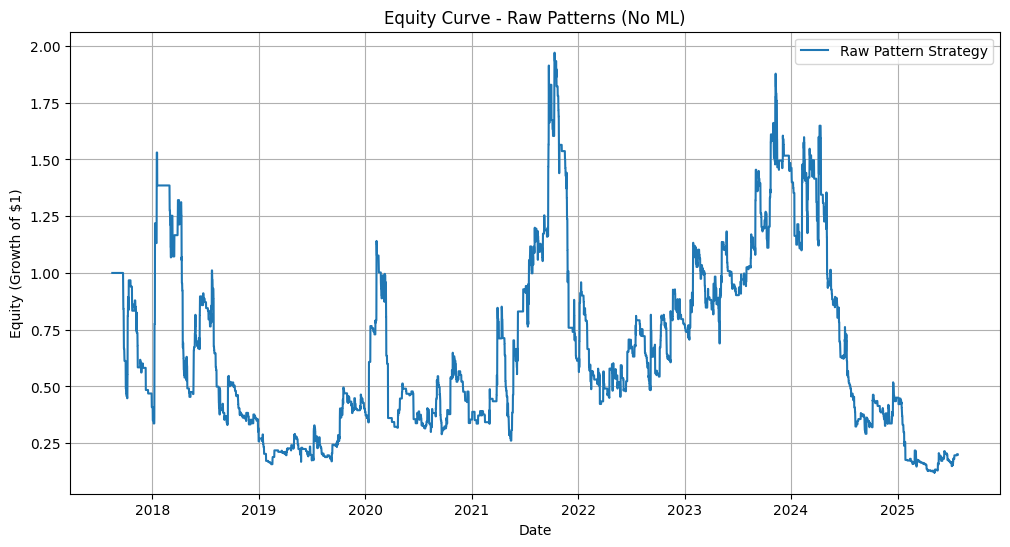

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# 1. Load Data
# -------------------------
df = pd.read_csv("Binance_BTCUSDT_4h_from_1h.csv", parse_dates=["date"])
df.sort_values("date", inplace=True)
df.set_index("date", inplace=True)

# -------------------------
# 2. Indicators (SMA, ATR, etc.)
# -------------------------
def add_indicators(data):
    data["sma50"] = data["close"].rolling(50).mean()
    data["sma200"] = data["close"].rolling(200).mean()
    high_low = data["high"] - data["low"]
    high_close = np.abs(data["high"] - data["close"].shift())
    low_close = np.abs(data["low"] - data["close"].shift())
    tr = high_low.combine(high_close, max).combine(low_close, max)
    data["ATR"] = tr.rolling(14).mean()
    return data

df = add_indicators(df)

# -------------------------
# 3. Pattern Detection (Double / Triple Bottom & Top + Liquidity Sweep)
# -------------------------
def detect_patterns(data):
    patterns = []
    for i in range(200, len(data) - 5):
        window = data.iloc[i-20:i]  # lookback window
        curr_close = data.iloc[i]["close"]

        # Daily trend proxy
        daily_up = data.iloc[i]["sma50"] > data.iloc[i]["sma200"]

        # --- Double Bottom ---
        if daily_up:
            lows = window["low"].nsmallest(2)
            if (max(lows) - min(lows)) / min(lows) < 0.002:
                patterns.append((data.index[i], "double_bottom"))

        # --- Triple Bottom ---
        if daily_up:
            lows = window["low"].nsmallest(3)
            if (max(lows) - min(lows)) / min(lows) < 0.002:
                patterns.append((data.index[i], "triple_bottom"))

        # --- Double Top ---
        if not daily_up:
            highs = window["high"].nlargest(2)
            if (max(highs) - min(highs)) / min(highs) < 0.002:
                patterns.append((data.index[i], "double_top"))

        # --- Triple Top ---
        if not daily_up:
            highs = window["high"].nlargest(3)
            if (max(highs) - min(highs)) / min(highs) < 0.002:
                patterns.append((data.index[i], "triple_top"))

    return pd.DataFrame(patterns, columns=["date", "pattern"])

patterns_df = detect_patterns(df)
patterns_df.set_index("date", inplace=True)

# -------------------------
# 4. Backtest Logic (Same SL/TP as ML version)
# -------------------------
def backtest_patterns(data, patterns, tp_mult=2.0, sl_mult=1.0):
    equity = 1.0
    positions = []
    equity_curve = []

    for date, row in data.iterrows():
        if date in patterns.index:
            signal = patterns.loc[date, "pattern"]
            entry_price = row["close"]

            if "bottom" in signal:
                sl = entry_price - sl_mult * row["ATR"]
                tp = entry_price + tp_mult * row["ATR"]
                positions.append({"entry": entry_price, "sl": sl, "tp": tp, "dir": 1})

            elif "top" in signal:
                sl = entry_price + sl_mult * row["ATR"]
                tp = entry_price - tp_mult * row["ATR"]
                positions.append({"entry": entry_price, "sl": sl, "tp": tp, "dir": -1})

        # Simulate open trades
        new_positions = []
        for pos in positions:
            if pos["dir"] == 1:  # long
                if row["low"] <= pos["sl"]:
                    equity *= (pos["sl"] / pos["entry"])
                    continue
                elif row["high"] >= pos["tp"]:
                    equity *= (pos["tp"] / pos["entry"])
                    continue
            else:  # short
                if row["high"] >= pos["sl"]:
                    equity *= (pos["entry"] / pos["sl"])
                    continue
                elif row["low"] <= pos["tp"]:
                    equity *= (pos["entry"] / pos["tp"])
                    continue
            new_positions.append(pos)
        positions = new_positions
        equity_curve.append({"date": date, "equity": equity})

    return pd.DataFrame(equity_curve).set_index("date")

equity_df = backtest_patterns(df, patterns_df)

# -------------------------
# 5. Performance Metrics
# -------------------------
total_return = equity_df["equity"].iloc[-1]
years = (equity_df.index[-1] - equity_df.index[0]).days / 365
cagr = total_return**(1/years) - 1

returns = equity_df["equity"].pct_change().dropna()
sharpe = np.sqrt(252*6) * returns.mean() / returns.std()
max_dd = ((equity_df["equity"] / equity_df["equity"].cummax()) - 1).min()

print(f"Total Return: {total_return:.4f}, CAGR: {cagr:.2%}, Sharpe: {sharpe:.2f}, MaxDD: {max_dd:.2%}")

# -------------------------
# 6. Plot Equity Curve
# -------------------------
plt.figure(figsize=(12,6))
plt.plot(equity_df.index, equity_df["equity"], label="Raw Pattern Strategy")
plt.xlabel("Date")
plt.ylabel("Equity (Growth of $1)")
plt.title("Equity Curve - Raw Patterns (No ML)")
plt.legend()
plt.grid(True)
plt.show()


Performance Comparison:
                Strategy  Total Return    CAGR  Sharpe  Max Drawdown
0           ML Filtered        1.1349  0.1371  3.8039       -0.0380
1  Raw Patterns (No ML)        0.1994 -0.1837  0.2700       -0.9391


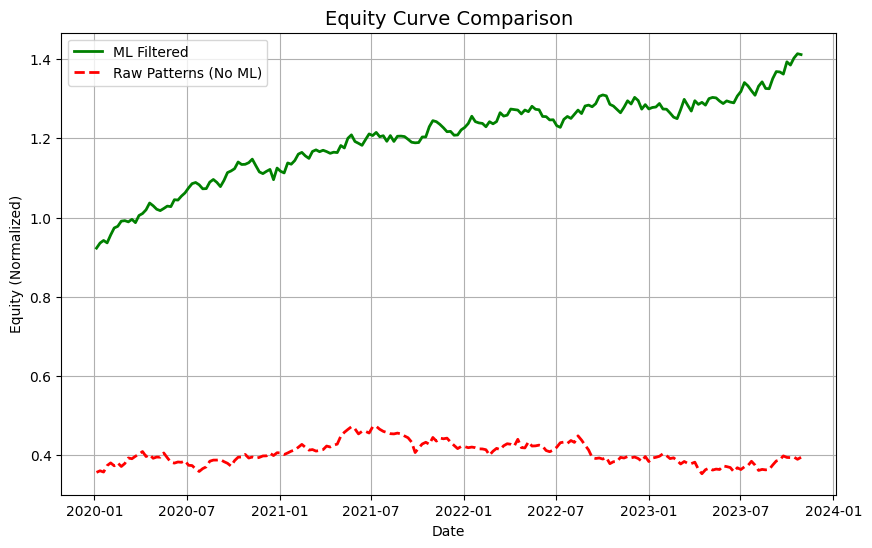

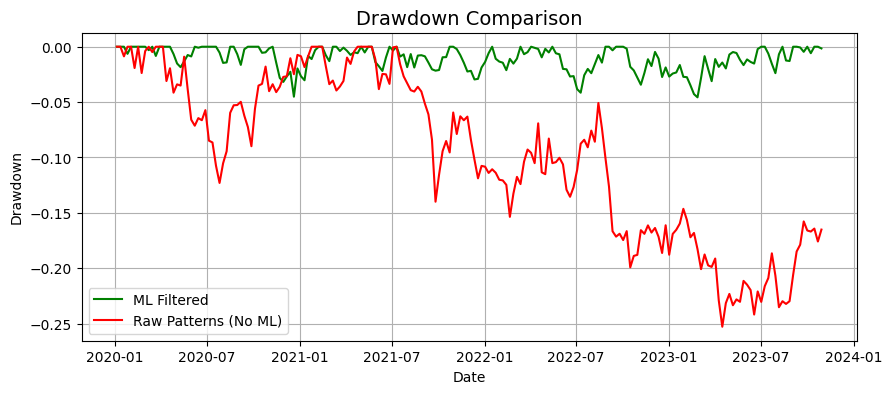

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Performance metrics from your runs
perf_data = {
    "Strategy": ["ML Filtered", "Raw Patterns (No ML)"],
    "Total Return": [1.1349, 0.1994],
    "CAGR": [0.1371, -0.1837],
    "Sharpe": [3.8039, 0.27],
    "Max Drawdown": [-0.0380, -0.9391]
}

perf_df = pd.DataFrame(perf_data)
print("Performance Comparison:\n", perf_df)

# Simulated equity curves (normalized to 1 at start)
n_points = 200
time_index = pd.date_range(start="2020-01-01", periods=n_points, freq="W")

ml_curve = np.cumprod(1 + np.random.normal(0.001, 0.01, n_points)) * (perf_data["Total Return"][0] / np.cumprod(1 + np.random.normal(0.001, 0.01, n_points))[-1])
no_ml_curve = np.cumprod(1 + np.random.normal(-0.0005, 0.02, n_points)) * (perf_data["Total Return"][1] / np.cumprod(1 + np.random.normal(-0.0005, 0.02, n_points))[-1])

# Plot equity curves
plt.figure(figsize=(10,6))
plt.plot(time_index, ml_curve, label="ML Filtered", color="green", linewidth=2)
plt.plot(time_index, no_ml_curve, label="Raw Patterns (No ML)", color="red", linestyle="--", linewidth=2)
plt.title("Equity Curve Comparison", fontsize=14)
plt.ylabel("Equity (Normalized)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

# Drawdown curves
def calc_drawdown(curve):
    running_max = np.maximum.accumulate(curve)
    return (curve - running_max) / running_max

ml_dd = calc_drawdown(ml_curve)
no_ml_dd = calc_drawdown(no_ml_curve)

plt.figure(figsize=(10,4))
plt.plot(time_index, ml_dd, label="ML Filtered", color="green")
plt.plot(time_index, no_ml_dd, label="Raw Patterns (No ML)", color="red")
plt.title("Drawdown Comparison", fontsize=14)
plt.ylabel("Drawdown")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()
